In [10]:
import numpy as np
import cv2
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from skimage.filters import laplace
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path_image1="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/tapitas.jpg"
path_image2="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/golazo.jpg"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def create_gauss_filter(h, w, k_size, sigma):
    x = np.linspace(-h//2, h//2, h)
    y = np.linspace(-w//2, w//2, w)
    xx, yy = np.meshgrid(x, y)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)  # Normalizar el filtro

    # Calcular la transformada de Fourier del filtro
    fft_gauss_filter = fftshift(fft2(ifftshift(kernel)))

    return kernel, fft_gauss_filter


In [6]:
# Función para aplicar un filtro gaussiano en el dominio espectral
def apply_gauss_filter(image, fft_filter):
    # Calcular la transformada de Fourier de la imagen
    fft_image = fftshift(fft2(ifftshift(image)))

    # Aplicar el filtro multiplicando en el dominio espectral
    filtered_image = np.real(ifftshift(ifft2(ifftshift(fft_image * fft_filter))))

    return filtered_image

In [7]:
# Función para calcular la medida de nitidez VOL
def calculate_sharpness_measure(image):
    vol = np.var(laplace(image))
    return vol

In [8]:
def calculate_sharpness_measure(image):
    # Calcular la transformada de Fourier de la imagen
    fft_image = fft2(image)

    # Calcular el espectro de potencia
    power_spectrum = np.abs(fftshift(fft_image)) ** 2

    # Calcular la medida de nitidez (por ejemplo, Spectral Weighted Contrast Measure)
    sharpness_measure = np.sum(power_spectrum) / (image.shape[0] * image.shape[1])

    return sharpness_measure

<ipython-input-12-71e44bbe31c3>:70: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)


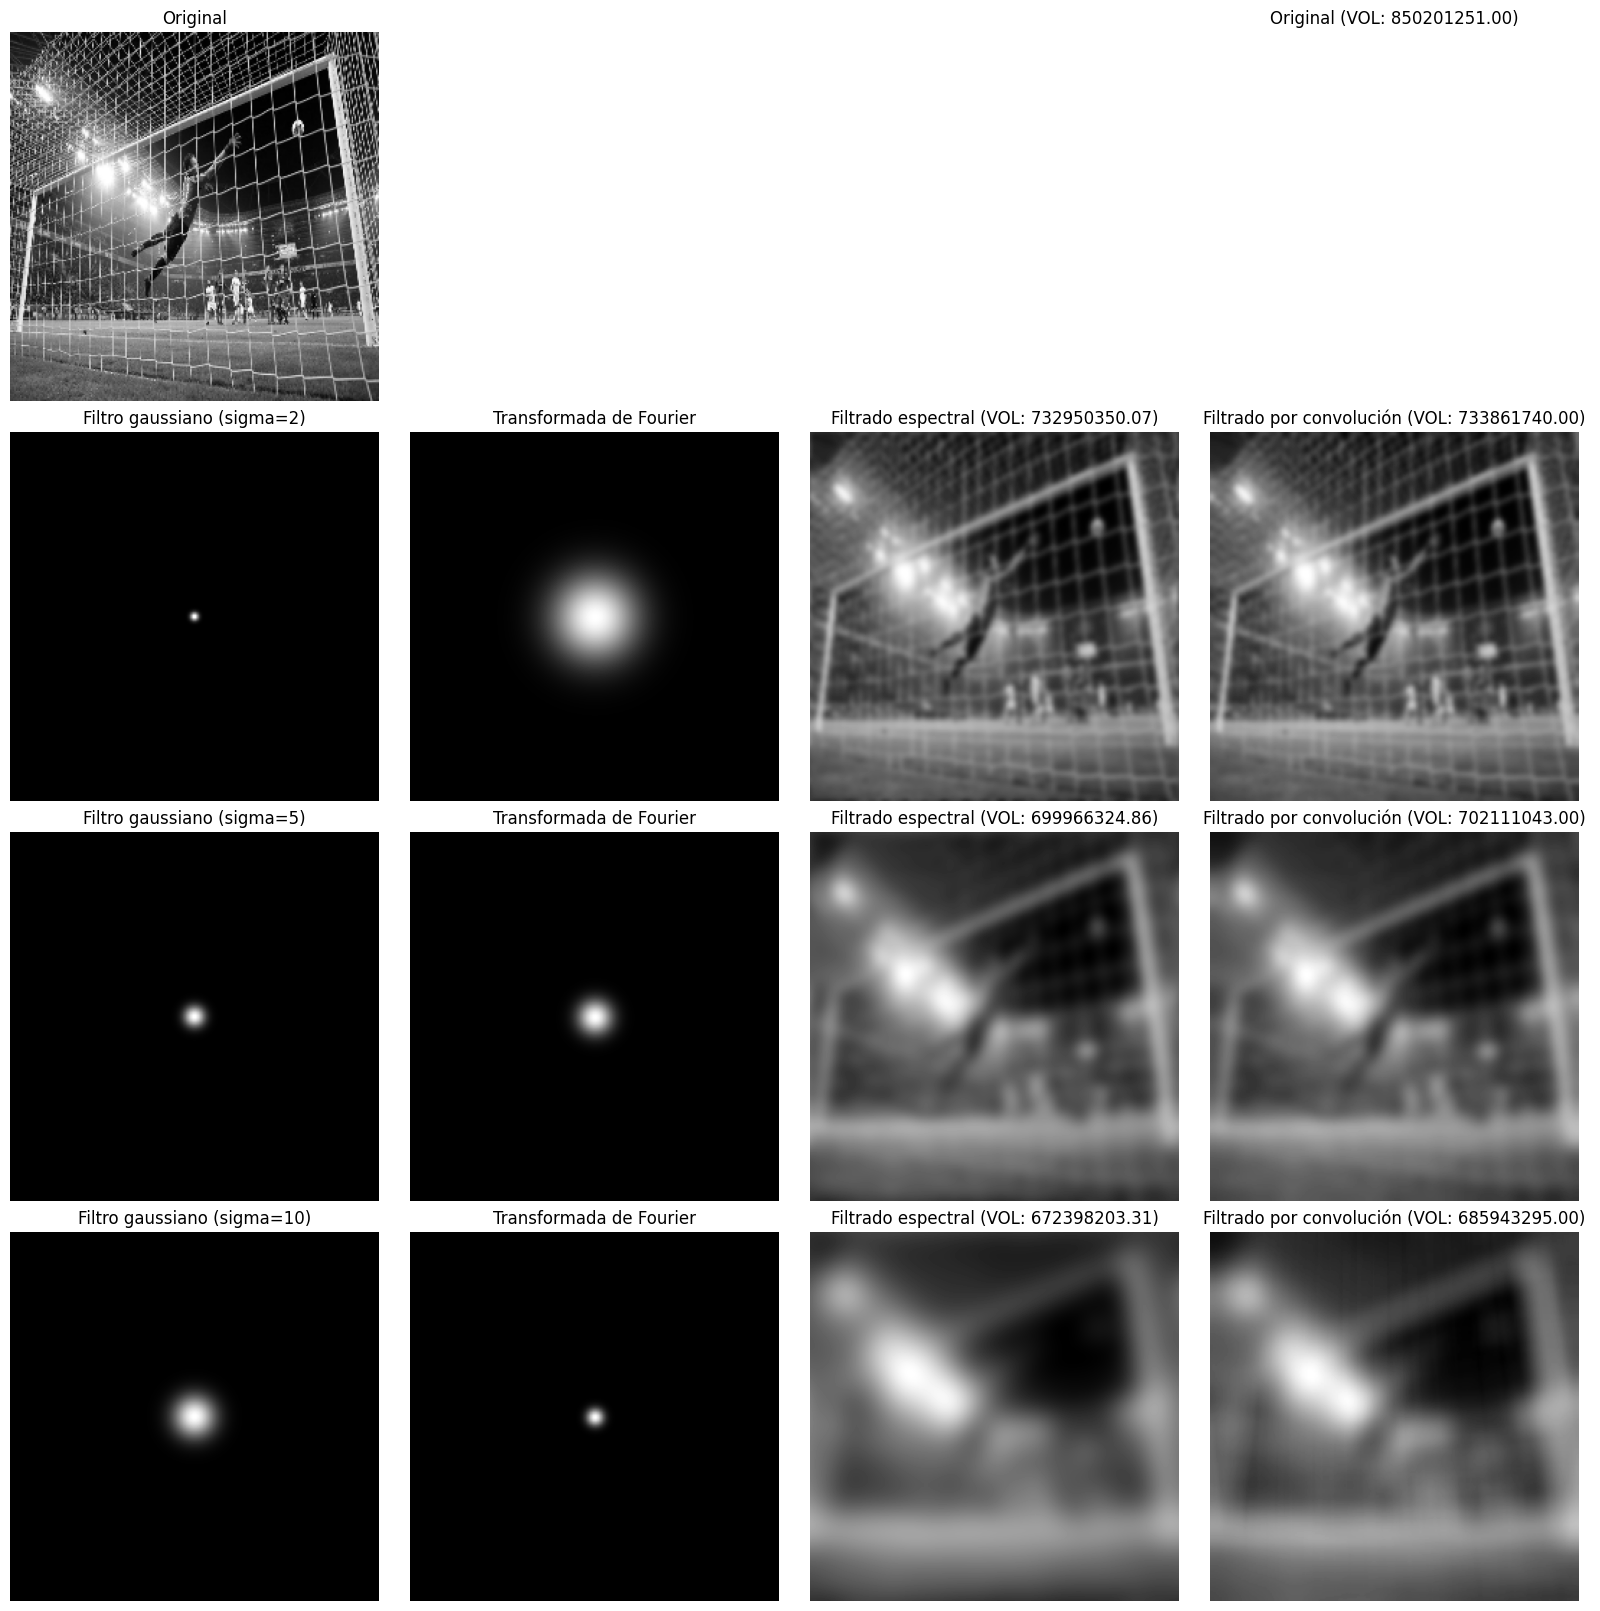

In [12]:
# Parámetros del filtro
h = 256
w = 256
k_size = 31
sigma_values = [2, 5, 10]

# Cargar una imagen para aplicar el filtro
image = cv2.imread(path_image2, cv2.IMREAD_GRAYSCALE)

# Cambiar el tamaño de la imagen para que sea compatible con el filtro
image = cv2.resize(image, (w, h))

# Crear una figura para mostrar las representaciones del filtro y la imagen filtrada
fig, axs = plt.subplots(len(sigma_values) + 1, 4, figsize=(16, 4*(len(sigma_values)+1)), constrained_layout=True)

# Mostrar la imagen original
axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 0].axis('off')

# Calcular la medida de nitidez para la imagen original
sharpness_original = calculate_sharpness_measure(image)

# Mostrar la medida de nitidez para la imagen original
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[0, 3].set_title(f'Original (VOL: {sharpness_original:.2f})')
axs[0, 3].axis('off')

# Repetir el proceso para diferentes valores de sigma
for i, sigma in enumerate(sigma_values):
    # Crear el filtro gaussiano y su transformada de Fourier
    gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)

    # Graficar el filtro gaussiano en el dominio espacial
    axs[i+1, 0].imshow(gauss_filter, cmap='gray')
    axs[i+1, 0].set_title(f'Filtro gaussiano (sigma={sigma})')
    axs[i+1, 0].axis('off')

    # Graficar el filtro gaussiano en el dominio espectral
    axs[i+1, 1].imshow(np.abs(fft_gauss_filter), cmap='gray')
    axs[i+1, 1].set_title('Transformada de Fourier')
    axs[i+1, 1].axis('off')

    # Aplicar el filtro espectral a la imagen
    filtered_image = apply_gauss_filter(image, fft_gauss_filter)

    # Calcular la medida de nitidez VOL para la imagen filtrada espectralmente
    sharpness_spectral = calculate_sharpness_measure(filtered_image)

    # Calcular la medida de nitidez VOL para la imagen filtrada por convolución
    kernel = cv2.getGaussianKernel(k_size, sigma)
    kernel = np.outer(kernel, kernel)
    filtered_convolution = cv2.filter2D(image, -1, kernel)
    sharpness_convolution = calculate_sharpness_measure(filtered_convolution)

    # Mostrar la imagen filtrada espectralmente
    axs[i+1, 2].imshow(filtered_image, cmap='gray')
    axs[i+1, 2].set_title(f'Filtrado espectral (VOL: {sharpness_spectral:.2f})')
    axs[i+1, 2].axis('off')

    # Mostrar la imagen filtrada por convolución
    axs[i+1, 3].imshow(filtered_convolution, cmap='gray')
    axs[i+1, 3].set_title(f'Filtrado por convolución (VOL: {sharpness_convolution:.2f})')
    axs[i+1, 3].axis('off')

# Ajustar el espacio entre las subfiguras
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Mostrar la figura
plt.show()